**The Fifteenth chapter of Hands-on Machine learning with Scikit-Learn, Keras, and Tensorflow's Ninth Exercise.**

Find the book from → [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd edition)](https://homl.info/er3)

Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.

In [19]:
import tensorflow as tf
from pathlib import Path
import numpy as np

In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
tf_download_url = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_url + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 [==============================] - 9s 0us/step


In [8]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob('training.tfrecord-*')]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob('eval.tfrecord-*')]
)

In [9]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [10]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [11]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [12]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [14]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [15]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [16]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [17]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [18]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[ 0.08235294 -0.16666666  0.        ]
  [ 0.0784314  -0.06060606  0.        ]
  [ 0.12156862 -0.03030303  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.12612614  0.32156864  0.        ]
  [ 0.05855855  0.2235294   0.        ]
  [ 0.4054054   0.05882353  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.2784314  -0.51824814  1.        ]
  [ 0.01960784 -0.02919708  0.        ]
  [ 0.          0.09489051  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.07017544  0.11372551  0.        ]
  [-0.06140351  0.15686274  0.        ]
  [ 0.          0.15294117  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

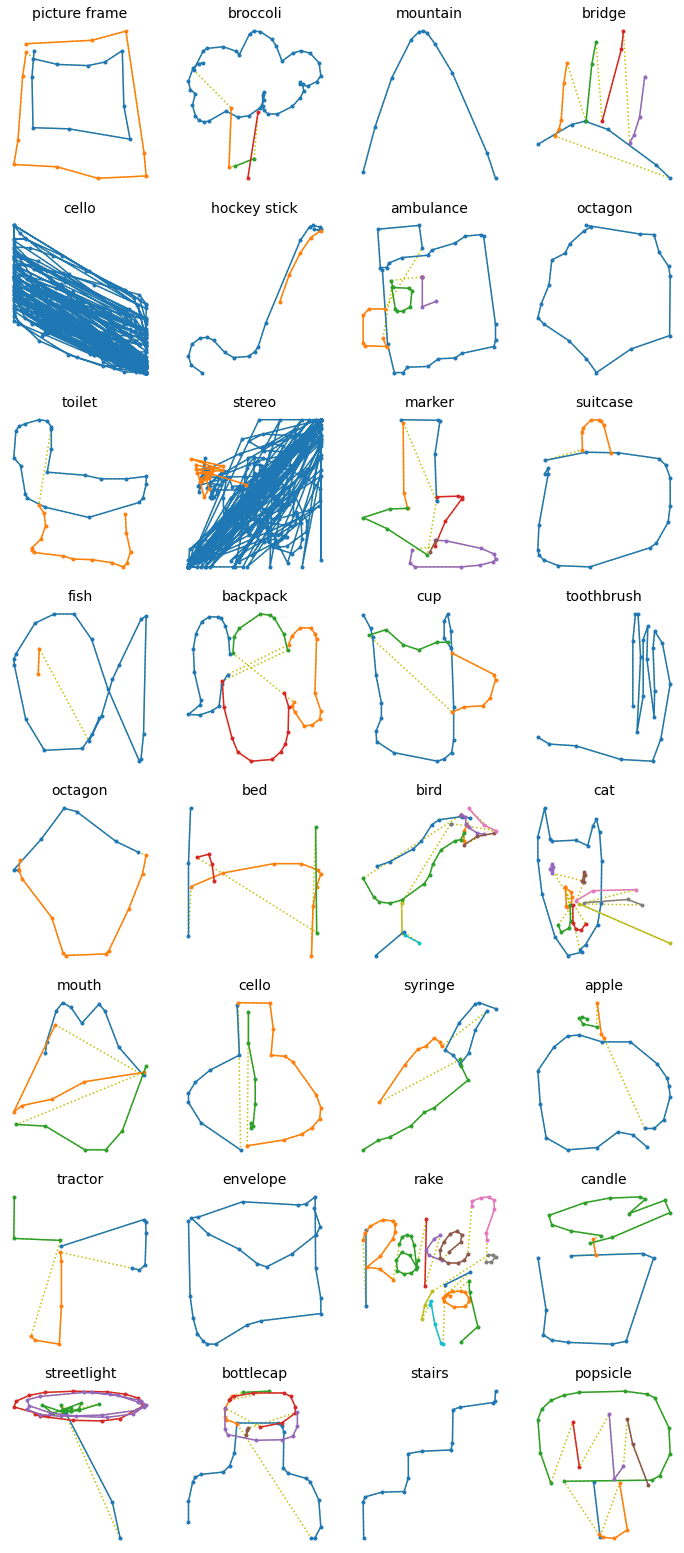

In [20]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

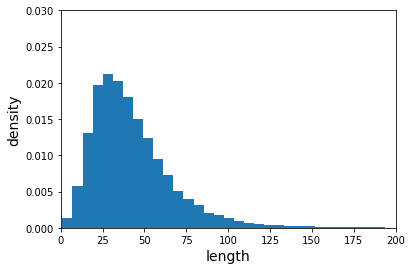

In [21]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

We need to crop our dataset in order to remove additional data as a trade off for accelerating training computation

In [22]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1409s 13ms/step - loss: 4.1298 - accuracy: 0.1617 - sparse_top_k_categorical_accuracy: 0.3633 - val_loss: 3.1484 - val_accuracy: 0.2966 - val_sparse_top_k_categorical_accuracy: 0.5790
Epoch 2/2
107813/107813 [==============================] - 1334s 12ms/step - loss: 2.7566 - accuracy: 0.3701 - sparse_top_k_categorical_accuracy: 0.6589 - val_loss: 2.5153 - val_accuracy: 0.4126 - val_sparse_top_k_categorical_accuracy: 0.7038


In [24]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 26s 5ms/step


In [25]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.5860208

1/1 [==============================] - 3s 3s/step


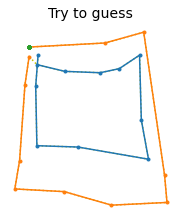

Top-5 predictions:
  1. ocean 19.694%
  2. stairs 15.209%
  3. fork 6.499%
  4. the great wall of china 4.348%
  5. line 3.793%
Answer: picture frame


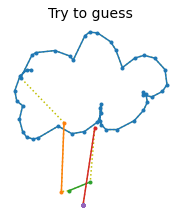

Top-5 predictions:
  1. rain 77.837%
  2. sheep 2.168%
  3. animal migration 2.126%
  4. chair 1.269%
  5. horse 1.175%
Answer: broccoli


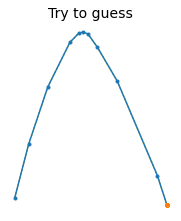

Top-5 predictions:
  1. squiggle 33.836%
  2. zigzag 8.035%
  3. ocean 7.218%
  4. line 6.665%
  5. animal migration 5.913%
Answer: mountain


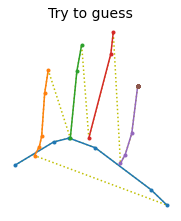

Top-5 predictions:
  1. rain 48.540%
  2. animal migration 9.277%
  3. ocean 4.067%
  4. hedgehog 3.414%
  5. rake 3.034%
Answer: bridge


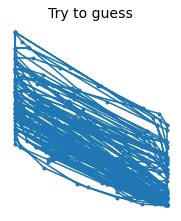

Top-5 predictions:
  1. hurricane 16.620%
  2. tornado 6.386%
  3. camouflage 5.545%
  4. blackberry 4.569%
  5. spreadsheet 2.933%
Answer: cello


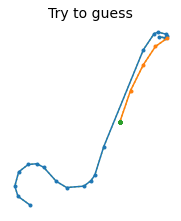

Top-5 predictions:
  1. stairs 18.596%
  2. ocean 12.196%
  3. squiggle 9.424%
  4. snake 8.177%
  5. garden hose 5.958%
Answer: hockey stick


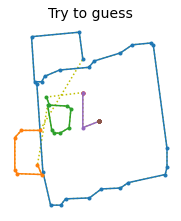

Top-5 predictions:
  1. rain 76.086%
  2. animal migration 3.303%
  3. sheep 1.334%
  4. fork 1.203%
  5. octopus 0.830%
Answer: ambulance


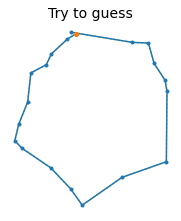

Top-5 predictions:
  1. ocean 13.202%
  2. river 12.959%
  3. animal migration 8.459%
  4. squiggle 7.056%
  5. moustache 4.675%
Answer: octagon


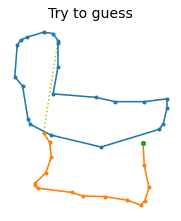

Top-5 predictions:
  1. ocean 25.305%
  2. animal migration 15.316%
  3. river 7.150%
  4. rain 4.963%
  5. the great wall of china 4.716%
Answer: toilet


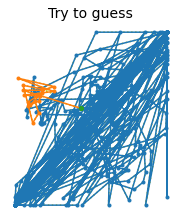

Top-5 predictions:
  1. grass 8.810%
  2. nail 7.622%
  3. the great wall of china 6.970%
  4. hurricane 6.957%
  5. feather 5.710%
Answer: stereo


In [26]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [27]:
model.save("my_sketchrnn", save_format="tf")